## Van Loan discretization of a stochastic driven damped harmonic oscillator

Wouter Kouw, last update: 06-11-2022

### System

Consider a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators) with displacement $x(t)$, driving force $u(t)$ and noise $w(t)$. The continuous-time dynamics of the system are:

$$\begin{align*}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) + w(t)\, ,
\end{align*}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} 
$$
constitute the physical parameters. 

#### Multivariate first-order system

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u + \frac{1}{m} w \, .$$

With the variable substitution $z = [x \ x']$, I cast the above system into a multi-variate first-order form:

$$ \begin{bmatrix} x' \\ x'' \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w\, .$$

#### Discretization

For the Van Loan discretization of the Wiener process, I first consider a first-order approximation of the matrix exponential of the transition matrix: 

$$F(t) = I + \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} t \, .$$

Then, I will consider the continuous-time covariance matrix of the noise in multi-variate form:

$$\mathbb{V}[\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w] = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} \mathbb{V}[w] \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}^{\top} = \begin{bmatrix} 0 & 0 \\ 0 & \frac{\sigma^2}{m^2} \end{bmatrix} \triangleq C \, .$$

Now, I can integrate the evolution of the covariance matrix from over the duration of a time-step. If all time-steps are equally long, e.g., of size $\Delta t$, then

$$Q = \int_0^{\Delta t} F(t) C F(t)^{\top} dt = \frac{\sigma^2}{m^2} \begin{bmatrix} \frac{\Delta t^3}{3} & \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} \\ \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} & \frac{c^2}{m^2}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} + \Delta t \end{bmatrix} \, ,$$

where $\sigma^2 = \mathbb{V}[w]$. A forward Euler discretization for the state transition yields:

$$\begin{align*} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u_k \, ,
\end{align*}$$

So, we end up with:

$$\begin{align*}
z_k =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \frac{-k}{m} \Delta t & \frac{-c}{m} \Delta t + 1 \end{bmatrix}}_{A} z_{k-1} + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{m} \Delta t \end{bmatrix}}_{B} u_k + q_k \quad \text{where} \quad q_k \sim \mathcal{N}(0,Q) \, .
\end{align*}$$

If we add noisy observations of the displacement position, 

$$ y_k = \underbrace{\begin{bmatrix} 0 & 1 \end{bmatrix}}_{C} z_k + r_k \quad \text{where} \quad r_k \sim \mathcal{N}(0, R) \, .$$

then we have the following probabibilistic state-space model:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid Cz_k, R) \, .
\end{align}$$

We can simulate the behaviour of this system as follows:

In [63]:
using LinearAlgebra
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)

In [68]:
# System parameters
m = 1.5
c = 0.9
k = 1.0
σ = 0.01

# Temporal variables
Δt = 0.1
T  = 200
time = range(0, step=Δt, length=T)

# Matrices
A = [1 Δt; -k/m*Δt -c/m*Δt+1]
B = [0, Δt/m]
C = [1 0]
Q = σ^2/m^2*[Δt^3/3 -c/m*Δt^3/3+Δt^2/2;-c/m*Δt^3/3+Δt^2/2 c^2/m^2*Δt^3/3+Δt^2/2+Δt]
R = sqrt(1e-2)

# Control
u = sin.(2π .*time)
u = zeros(T)

# Initial state
z_0 = [1.0, 1.0]

# Preallocate
z = zeros(2,T)
y = zeros(T)

# Start recursion
z_kmin1 = z_0
for k in 1:T
    
    # State transition
    z[:,k] = rand(MvNormal(A*z_kmin1 + B*u[k], Q))
    
    # Noisy observation
    y[k] = rand(Normal(dot(C,z[:,k]), R))
    
    # Update recursion
    z_kmin1 = z[:,k]
    
end

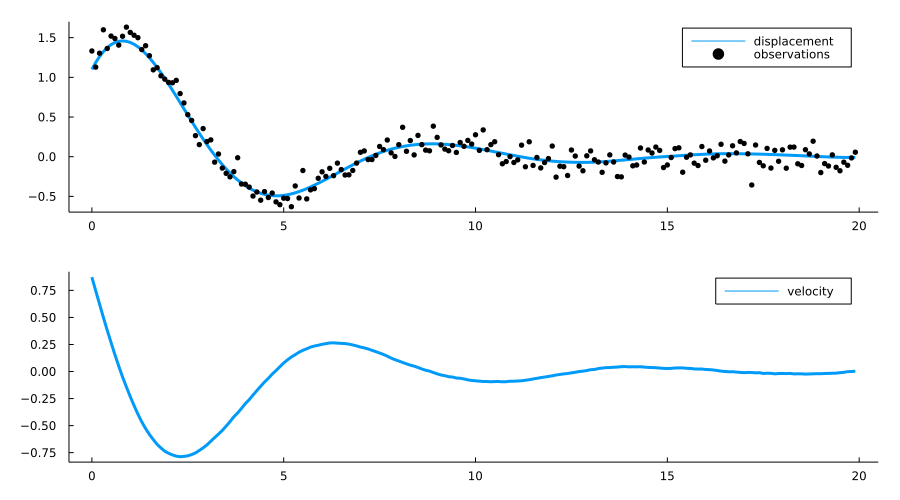

In [69]:
p1 = plot(time, z[1,:], label="displacement")
scatter!(time, y, color="black", label="observations")
p2 = plot(time, z[2,:], label="velocity")
plot(p1, p2, layout=(2,1), size=(900,500))